In [1]:
# Install YOLOv8 and necessary dependencies
!pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.5/913.5 kB 30.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [2]:
# Import wandb and log in
import wandb

# Log in to wandb with API key
wandb.login(key='8a1b95ea42f6c41ac024eae0d344b48f4b62a3f4')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# Define paths
root_dir = '/kaggle/input/cariesdetectionindian'
v1_dir = os.path.join(root_dir, '/kaggle/input/cariesdetectionindian')
#v2_dir = os.path.join(root_dir, '/kaggle/input/dentistryindianpaper/dentistry_dataset')

In [5]:
# Ensure the YOLOv8 data directories exist
os.makedirs('yolov11/data/caries_v1', exist_ok=True)
#os.makedirs('yolov11/data/caries_v2', exist_ok=True)

Displaying some training images from version 1:


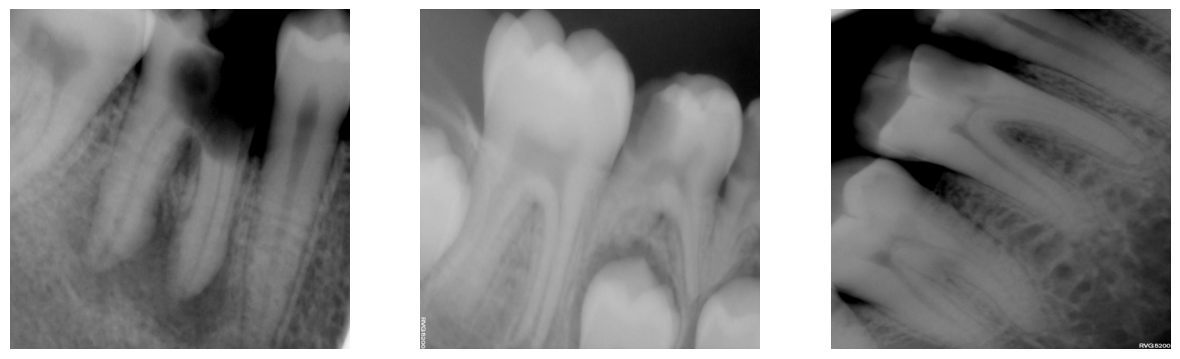

In [7]:
# Function to display images
def display_images(image_dir, num_images=3):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

# Display some training images
#print("Displaying some training images from version 2:")
#display_images(os.path.join(v2_dir, 'train/images'))


In [8]:
# Copy dataset to YOLOv8 directory
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

# Copy version 1 dataset
copy_dataset_to_yolo(v1_dir, 'yolov11/data/caries_v1')

# Copy version 2 dataset
#copy_dataset_to_yolo(v2_dir, 'yolov11/data/caries_v2')

In [9]:
# Update data.yaml paths
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# Update data.yaml for version 1
update_data_yaml('yolov11/data/caries_v1/data.yaml', '/kaggle/working/yolov11/data/caries_v1')

# Update data.yaml for version 2
#update_data_yaml('yolov11/data/caries_v2/data.yaml', '/kaggle/working/yolov11/data/caries_v2')

# Print and verify updated data.yaml files
def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml for version 1:")
print_data_yaml('yolov11/data/caries_v1/data.yaml')

#print("Updated data.yaml for version 2:")
#print_data_yaml('yolov11/data/caries_v2/data.yaml')

Updated data.yaml for version 1:
train: /kaggle/working/yolov11/data/caries_v1/train/images
val: /kaggle/working/yolov11/data/caries_v1/valid/images
test: /kaggle/working/yolov11/data/caries_v1/test/images


nc: 2
names: ['carries', 'deep carries']

roboflow:
  workspace: cropweed-ip5ij
  project: dheeraj-dentistry
  version: 1
  license: CC BY 4.0
  url: https://universe.roboflow.com/cropweed-ip5ij/dheeraj-dentistry/dataset/1


In [11]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))
#v2_train_labels = load_labels(os.path.join(v2_dir, 'train/labels'))

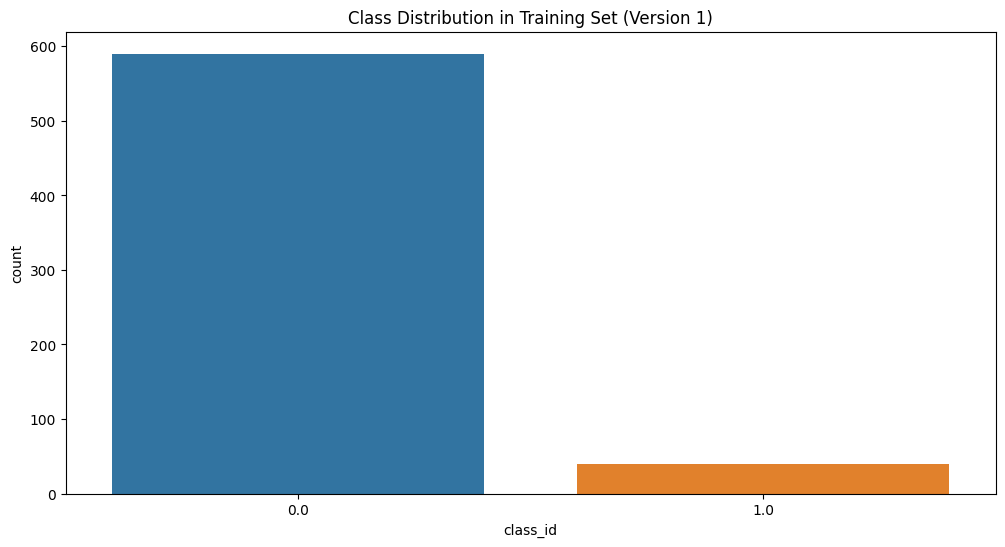

In [12]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

In [11]:
#plt.figure(figsize=(12, 6))
#sns.countplot(data=v2_train_labels, x='class_id')
#plt.title('Class Distribution in Training Set (Version 2)')
#plt.show()

In [13]:
from ultralytics import YOLO
# Train YOLOv11 model with augmentation and hyperparameter tuning
# Initialize model
model = YOLO("yolo11n.pt")

100%|██████████| 5.35M/5.35M [00:00<00:00, 192MB/s]


In [14]:
# Train model on version 1 dataset
model.train(data='/kaggle/working/yolov11/data/caries_v1/data.yaml', 
            epochs=100, 
            imgsz=640, 
            batch=16, 
            name='caries_v1_aug', 
            lr0=0.01, 
            momentum=0.937, 
            weight_decay=0.0005, 
            warmup_epochs=3.0, 
            warmup_momentum=0.8, 
            warmup_bias_lr=0.1,
            box=0.05, 
            cls=0.5, 
            iou=0.2, 
            hsv_h=0.015, 
            hsv_s=0.7, 
            hsv_v=0.4, 
            translate=0.1, 
            scale=0.5, 
            mosaic=1.0, 
            mixup=0.5,
           plots=True)

Ultralytics 8.3.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/yolov11/data/caries_v1/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=caries_v1_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

100%|██████████| 755k/755k [00:00<00:00, 44.4MB/s]
2025-01-26 11:18:20,862	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-26 11:18:21,564	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/yolov11/data/caries_v1/train/labels... 842 images, 341 backgrounds, 0 corrupt: 100%|██████████| 842/842 [00:00<00:00, 1634.74it/s]

train: New cache created: /kaggle/working/yolov11/data/caries_v1/train/labels.cache


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/yolov11/data/caries_v1/valid/labels... 194 images, 80 backgrounds, 0 corrupt: 100%|██████████| 194/194 [00:00<00:00, 823.16it/s]

val: New cache created: /kaggle/working/yolov11/data/caries_v1/valid/labels.cache



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Plotting labels to runs/detect/caries_v1_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/caries_v1_aug
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.67G    0.01715      4.683      2.421         18        640: 100%|██████████| 53/53 [00:13<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        194        134    0.00258      0.597     0.0207    0.00655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.67G    0.01645       3.96      2.383         23        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  5.76it/s]

                   all        194        134      0.566      0.064     0.0318    0.00921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.63G    0.01648      3.691      2.337         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.47it/s]


                   all        194        134      0.161      0.203     0.0956     0.0318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.63G    0.01643       3.46      2.381         27        640: 100%|██████████| 53/53 [00:10<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]

                   all        194        134      0.337      0.299      0.214     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.63G    0.01608      3.315      2.296         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]

                   all        194        134      0.554       0.04     0.0761     0.0157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.62G    0.01589      3.086      2.315         23        640: 100%|██████████| 53/53 [00:10<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]

                   all        194        134      0.232       0.14      0.106      0.025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.63G    0.01586      3.215      2.363         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]

                   all        194        134      0.296      0.319      0.168     0.0559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.63G    0.01518      2.966      2.292         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]

                   all        194        134      0.422      0.227      0.254      0.092



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.63G     0.0155      2.986      2.283         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.36it/s]

                   all        194        134      0.284      0.315      0.212     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.62G    0.01547       2.88      2.304         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]

                   all        194        134      0.296      0.509      0.251     0.0692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.63G    0.01529        2.9      2.255         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]

                   all        194        134     0.0807      0.752      0.193     0.0532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.63G    0.01496      2.884      2.216         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]

                   all        194        134      0.331      0.426      0.291      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.63G    0.01509      2.859      2.297         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]

                   all        194        134      0.478      0.274      0.282      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.62G    0.01473      2.749      2.228         25        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]

                   all        194        134      0.394       0.43      0.362      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.63G    0.01488      2.756      2.241         22        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]

                   all        194        134      0.288      0.267      0.224      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.63G      0.015      2.763      2.281         21        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]

                   all        194        134      0.463      0.348      0.393      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.63G     0.0146      2.701      2.226         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.357      0.482      0.247     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.62G    0.01469      2.674      2.213         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]

                   all        194        134      0.363      0.327      0.223     0.0725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.65G    0.01503       2.71      2.232         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]

                   all        194        134      0.305      0.362      0.367      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.63G    0.01458      2.711      2.197         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]

                   all        194        134       0.45      0.346      0.282     0.0912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.63G    0.01434      2.611      2.159         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]

                   all        194        134      0.574       0.45      0.448      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.62G    0.01454      2.619      2.173         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]

                   all        194        134      0.598      0.318      0.401      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.63G    0.01419      2.557      2.181         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]

                   all        194        134      0.543       0.43      0.414      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.63G    0.01416      2.574       2.18         16        640: 100%|██████████| 53/53 [00:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]

                   all        194        134      0.204      0.418      0.245     0.0909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.66G    0.01407      2.504      2.151         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]

                   all        194        134      0.564      0.418      0.448      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.67G    0.01429      2.512       2.15         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.465      0.343      0.387      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.63G    0.01421      2.542      2.155         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]

                   all        194        134        0.4      0.474      0.341      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.63G    0.01401      2.476      2.167         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]

                   all        194        134      0.577      0.423      0.532      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.63G    0.01443      2.482      2.161         24        640: 100%|██████████| 53/53 [00:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]

                   all        194        134      0.391      0.466      0.394      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.62G    0.01431      2.503      2.137         26        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

                   all        194        134      0.465      0.426      0.401      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.65G    0.01454      2.607      2.202         22        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]

                   all        194        134      0.513      0.373      0.366      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.63G    0.01391       2.45       2.11         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]

                   all        194        134      0.429      0.471      0.446      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.63G    0.01397      2.447      2.131         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]

                   all        194        134      0.509      0.522      0.477      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.62G    0.01419      2.551      2.185         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]

                   all        194        134      0.491      0.481      0.457      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.63G    0.01378      2.472      2.127         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.37it/s]

                   all        194        134      0.405      0.653      0.442      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.63G    0.01389      2.429      2.129         11        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]

                   all        194        134      0.416      0.458      0.426      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.63G    0.01384      2.366      2.123         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]

                   all        194        134      0.627      0.481      0.421      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.62G    0.01375      2.371      2.096         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]

                   all        194        134      0.438      0.419      0.409      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.63G    0.01402      2.438      2.147         10        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]

                   all        194        134      0.578      0.465      0.446      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.63G    0.01377      2.445      2.139         20        640: 100%|██████████| 53/53 [00:10<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.82it/s]

                   all        194        134      0.443      0.497      0.447      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.63G    0.01388      2.305      2.129         28        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]

                   all        194        134      0.671      0.481      0.572      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.62G    0.01372      2.291      2.088         25        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]

                   all        194        134      0.805      0.438      0.569      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.63G    0.01372      2.341       2.11         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]

                   all        194        134      0.599      0.384      0.418      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.63G    0.01395      2.341      2.119         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]

                   all        194        134      0.667      0.555      0.554      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.63G    0.01335      2.286      2.048         15        640: 100%|██████████| 53/53 [00:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


                   all        194        134      0.216      0.334      0.207     0.0639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.62G    0.01324      2.273      2.082         21        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]

                   all        194        134      0.654      0.644      0.616      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.65G    0.01307      2.205      2.057         18        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.48it/s]

                   all        194        134      0.681      0.629      0.653       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.63G    0.01314       2.23      2.044         13        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]

                   all        194        134      0.545      0.529      0.432      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.63G     0.0135      2.284      2.068         17        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]

                   all        194        134      0.495      0.625      0.522      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.64G    0.01336       2.27      2.076         25        640: 100%|██████████| 53/53 [00:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]

                   all        194        134      0.559       0.59      0.552      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.63G    0.01343      2.184      2.032         19        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]

                   all        194        134       0.52      0.516      0.528      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.63G    0.01323      2.208      2.065         28        640: 100%|██████████| 53/53 [00:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]

                   all        194        134      0.582      0.573      0.547       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.63G     0.0133      2.181      2.071         26        640: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]

                   all        194        134      0.534      0.628       0.64      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.62G    0.01296       2.13       2.05         22        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]

                   all        194        134      0.804      0.581      0.651      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.63G    0.01313      2.118      2.057         14        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]

                   all        194        134      0.668      0.497      0.597      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.63G      0.013      2.154      2.034         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.00it/s]

                   all        194        134      0.566      0.724      0.681      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.63G    0.01295      2.023      2.016         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]

                   all        194        134      0.656      0.637      0.641      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.62G    0.01295      2.057      2.031         22        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]

                   all        194        134      0.791      0.521      0.662      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.63G    0.01283      2.151      2.013          7        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]

                   all        194        134      0.723      0.677      0.726      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.63G      0.013      2.062      2.039         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]

                   all        194        134      0.495      0.728      0.532      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.63G    0.01273      2.095      2.019         23        640: 100%|██████████| 53/53 [00:11<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]

                   all        194        134      0.603      0.681      0.678      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.62G    0.01287      2.043      2.007         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]

                   all        194        134      0.661      0.605      0.675      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.63G    0.01269      2.036      1.971         24        640: 100%|██████████| 53/53 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]

                   all        194        134      0.782      0.633      0.695      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.63G    0.01267      2.042      1.995         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.68it/s]


                   all        194        134      0.741       0.74      0.702      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.63G    0.01233       1.96      1.954         12        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]

                   all        194        134      0.619      0.543      0.612      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.64G    0.01288      2.052      2.022         20        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]

                   all        194        134      0.618      0.629      0.648      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.63G    0.01259      1.982      1.988         23        640: 100%|██████████| 53/53 [00:11<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.72it/s]

                   all        194        134      0.547      0.629      0.607        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.65G    0.01241       1.96      1.958          8        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]

                   all        194        134      0.789      0.617      0.677      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.63G    0.01247       2.05      1.989         18        640: 100%|██████████| 53/53 [00:11<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]

                   all        194        134      0.776      0.637       0.72      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.62G    0.01242       1.94      1.983         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]

                   all        194        134      0.724      0.652      0.651      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.65G    0.01236      1.886       1.97         14        640: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]

                   all        194        134      0.816      0.625      0.728      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.63G    0.01255      1.946      1.975         23        640: 100%|██████████| 53/53 [00:11<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]

                   all        194        134      0.728      0.669       0.68       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.63G    0.01212      1.914      1.919         16        640: 100%|██████████| 53/53 [00:11<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]

                   all        194        134      0.656      0.697      0.677        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.62G    0.01227      1.889      1.959         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]

                   all        194        134      0.844      0.633       0.72      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.63G    0.01256        1.9      1.983         14        640: 100%|██████████| 53/53 [00:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]

                   all        194        134      0.686      0.722      0.712      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.63G    0.01215      1.935      1.963         21        640: 100%|██████████| 53/53 [00:11<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]

                   all        194        134      0.724      0.772      0.735      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.65G    0.01208       1.88      1.954         24        640: 100%|██████████| 53/53 [00:11<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.42it/s]

                   all        194        134       0.83      0.692      0.745      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.62G     0.0121      1.905      1.934         19        640: 100%|██████████| 53/53 [00:11<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]

                   all        194        134      0.857      0.593      0.716      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.63G    0.01196      1.855      1.927         19        640: 100%|██████████| 53/53 [00:10<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]

                   all        194        134       0.71      0.657      0.711      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.63G    0.01187      1.834      1.889         26        640: 100%|██████████| 53/53 [00:10<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]

                   all        194        134      0.828       0.62      0.692      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.63G    0.01165      1.783      1.861         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]

                   all        194        134       0.66      0.768      0.738      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.62G    0.01177      1.801      1.867         15        640: 100%|██████████| 53/53 [00:11<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]

                   all        194        134      0.703      0.695      0.686      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.63G    0.01189      1.782      1.887         11        640: 100%|██████████| 53/53 [00:11<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]

                   all        194        134      0.724      0.741      0.753      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.63G    0.01202      1.761       1.91         19        640: 100%|██████████| 53/53 [00:10<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.32it/s]

                   all        194        134      0.779      0.733      0.764      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.63G    0.01172      1.765      1.861         17        640: 100%|██████████| 53/53 [00:11<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]

                   all        194        134      0.785      0.673      0.771       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.62G    0.01152      1.781      1.847          9        640: 100%|██████████| 53/53 [00:11<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]

                   all        194        134      0.753      0.717      0.762      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.63G     0.0114      1.748      1.849         10        640: 100%|██████████| 53/53 [00:11<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]

                   all        194        134      0.633      0.758      0.689      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.64G    0.01178      1.737      1.875         21        640: 100%|██████████| 53/53 [00:11<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.49it/s]

                   all        194        134      0.831      0.621      0.718      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.65G    0.01154      1.748       1.86         18        640: 100%|██████████| 53/53 [00:10<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]

                   all        194        134      0.777       0.69      0.707      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.64G    0.01161      1.731      1.872         10        640: 100%|██████████| 53/53 [00:10<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]

                   all        194        134      0.706      0.647      0.699      0.351


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.63G     0.0101       1.47      1.757          5        640: 100%|██████████| 53/53 [00:11<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.54it/s]

                   all        194        134      0.706      0.756      0.748       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.63G    0.01001      1.294      1.753          6        640: 100%|██████████| 53/53 [00:10<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]

                   all        194        134      0.741      0.768      0.739       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.63G   0.009797      1.228      1.711          6        640: 100%|██████████| 53/53 [00:10<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  6.66it/s]

                   all        194        134       0.72      0.757      0.736       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.62G   0.009761      1.175      1.706         10        640: 100%|██████████| 53/53 [00:10<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]

                   all        194        134      0.755      0.693      0.751      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.63G   0.009401      1.118      1.654          9        640: 100%|██████████| 53/53 [00:10<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.47it/s]

                   all        194        134      0.784       0.63      0.753      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.63G   0.009387      1.116      1.661          6        640: 100%|██████████| 53/53 [00:10<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]

                   all        194        134      0.725      0.724      0.773      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.63G     0.0091      1.092      1.646          8        640: 100%|██████████| 53/53 [00:10<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]

                   all        194        134       0.75      0.821      0.792      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.62G   0.008925      1.047      1.611          7        640: 100%|██████████| 53/53 [00:10<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.46it/s]

                   all        194        134      0.881      0.649      0.766      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.63G   0.009074      1.058      1.622          6        640: 100%|██████████| 53/53 [00:10<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]

                   all        194        134      0.753      0.753      0.782      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.63G   0.008829      1.067      1.603          7        640: 100%|██████████| 53/53 [00:10<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]

                   all        194        134      0.728      0.807       0.79      0.398



100 epochs completed in 0.358 hours.
Optimizer stripped from runs/detect/caries_v1_aug/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/caries_v1_aug/weights/best.pt, 5.5MB

Validating runs/detect/caries_v1_aug/weights/best.pt...
Ultralytics 8.3.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


                   all        194        134       0.88      0.646      0.766      0.402
               carries        106        125      0.761      0.636      0.704      0.334
          deep carries          9          9          1      0.656      0.829      0.471
Speed: 0.2ms preprocess, 3.6ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/caries_v1_aug


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ae8aacb2110>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

Displaying results from model trained on version 1 with augmentation:

image 1/1 /kaggle/input/cariesdetectionindian/test/images/aug_R1-802-_jpg.rf.58329588859f301d52b478b05a333e95.jpg: 640x640 (no detections), 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


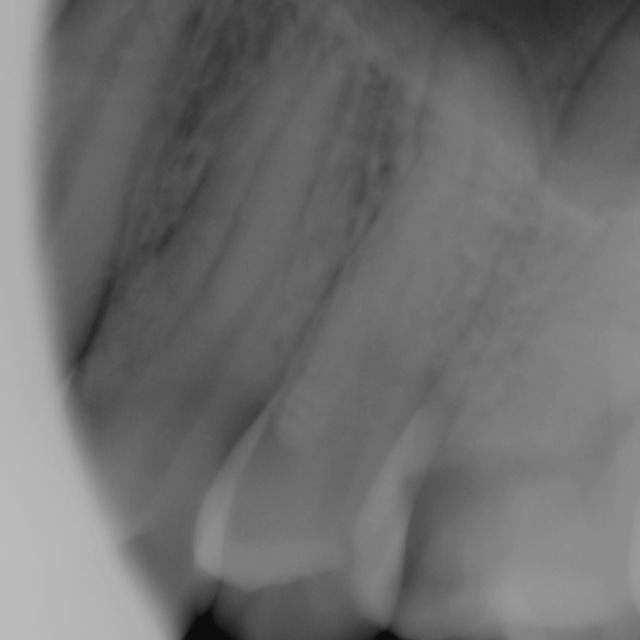


image 1/1 /kaggle/input/cariesdetectionindian/test/images/R1-474-_jpg.rf.1ef96d55a2a33c0137239831335355ab.jpg: 640x640 (no detections), 8.0ms
Speed: 1.4ms preprocess, 8.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


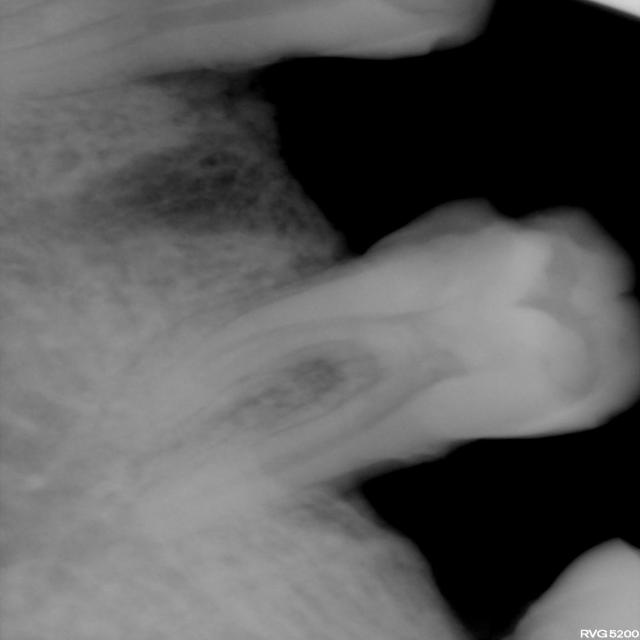


image 1/1 /kaggle/input/cariesdetectionindian/test/images/aug_R1-505-_jpg.rf.bc8113a0377464d393fa4a6955eaa95f.jpg: 640x640 1 carries, 7.6ms
Speed: 1.2ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


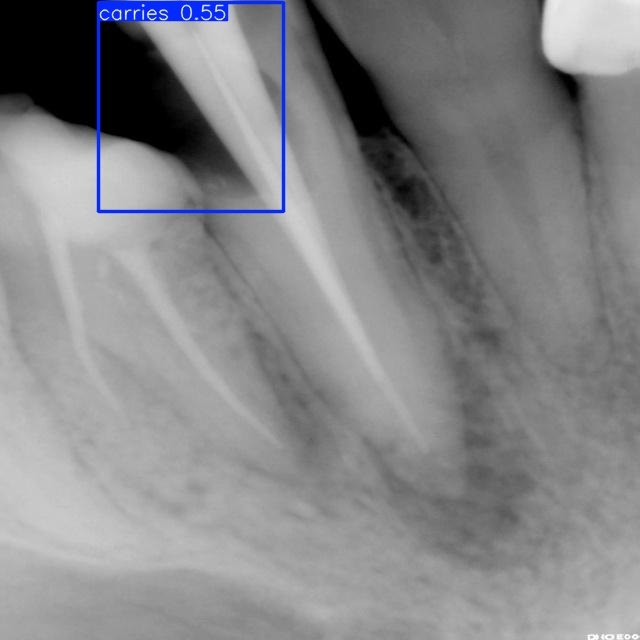


image 1/1 /kaggle/input/cariesdetectionindian/test/images/aug_R1-199-_jpg.rf.2d3c01ab68c3c1f7d85d7be47e4c62d6.jpg: 640x640 (no detections), 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


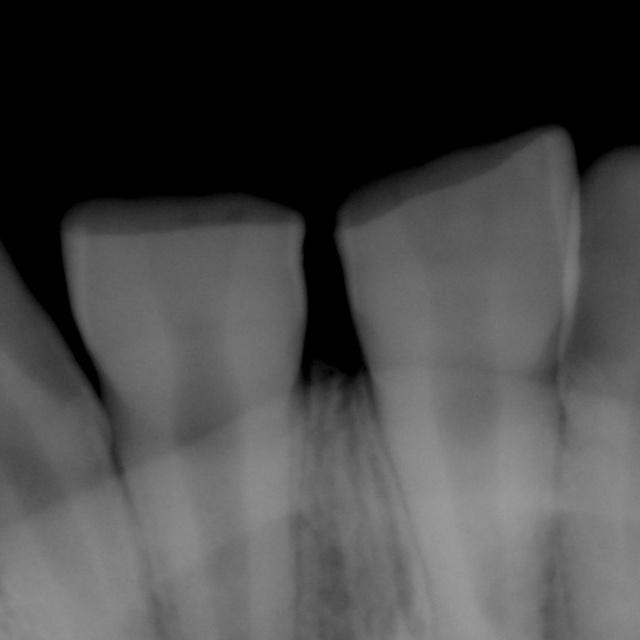


image 1/1 /kaggle/input/cariesdetectionindian/test/images/R1-883-_jpg.rf.73f3a164f7bddfa3c462067fdd4a7ab4.jpg: 640x640 1 carries, 7.9ms
Speed: 1.3ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


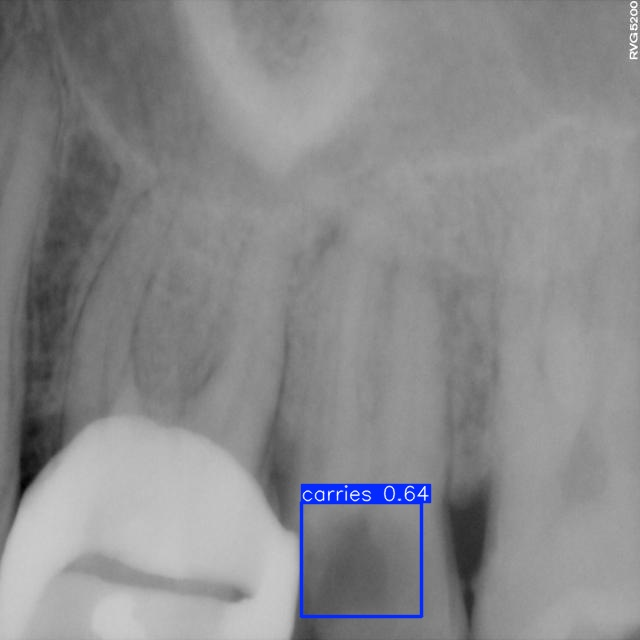

In [15]:
# Evaluate the model and display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)
    
    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print("Displaying results from model trained on version 1 with augmentation:")
display_results(model, os.path.join(v1_dir, 'test/images'))

#print("Displaying results from model trained on version 2 with augmentation:")
#display_results(model1, os.path.join(v2_dir, 'test/images'))


In [16]:
!ls /kaggle/working/runs/detect/caries_v1_aug/

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


F1_curve.png					  train_batch1.jpg
PR_curve.png					  train_batch2.jpg
P_curve.png					  train_batch4770.jpg
R_curve.png					  train_batch4771.jpg
args.yaml					  train_batch4772.jpg
confusion_matrix.png				  val_batch0_labels.jpg
confusion_matrix_normalized.png			  val_batch0_pred.jpg
events.out.tfevents.1737890312.c849fec631ba.34.0  val_batch1_labels.jpg
labels.jpg					  val_batch1_pred.jpg
labels_correlogram.jpg				  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


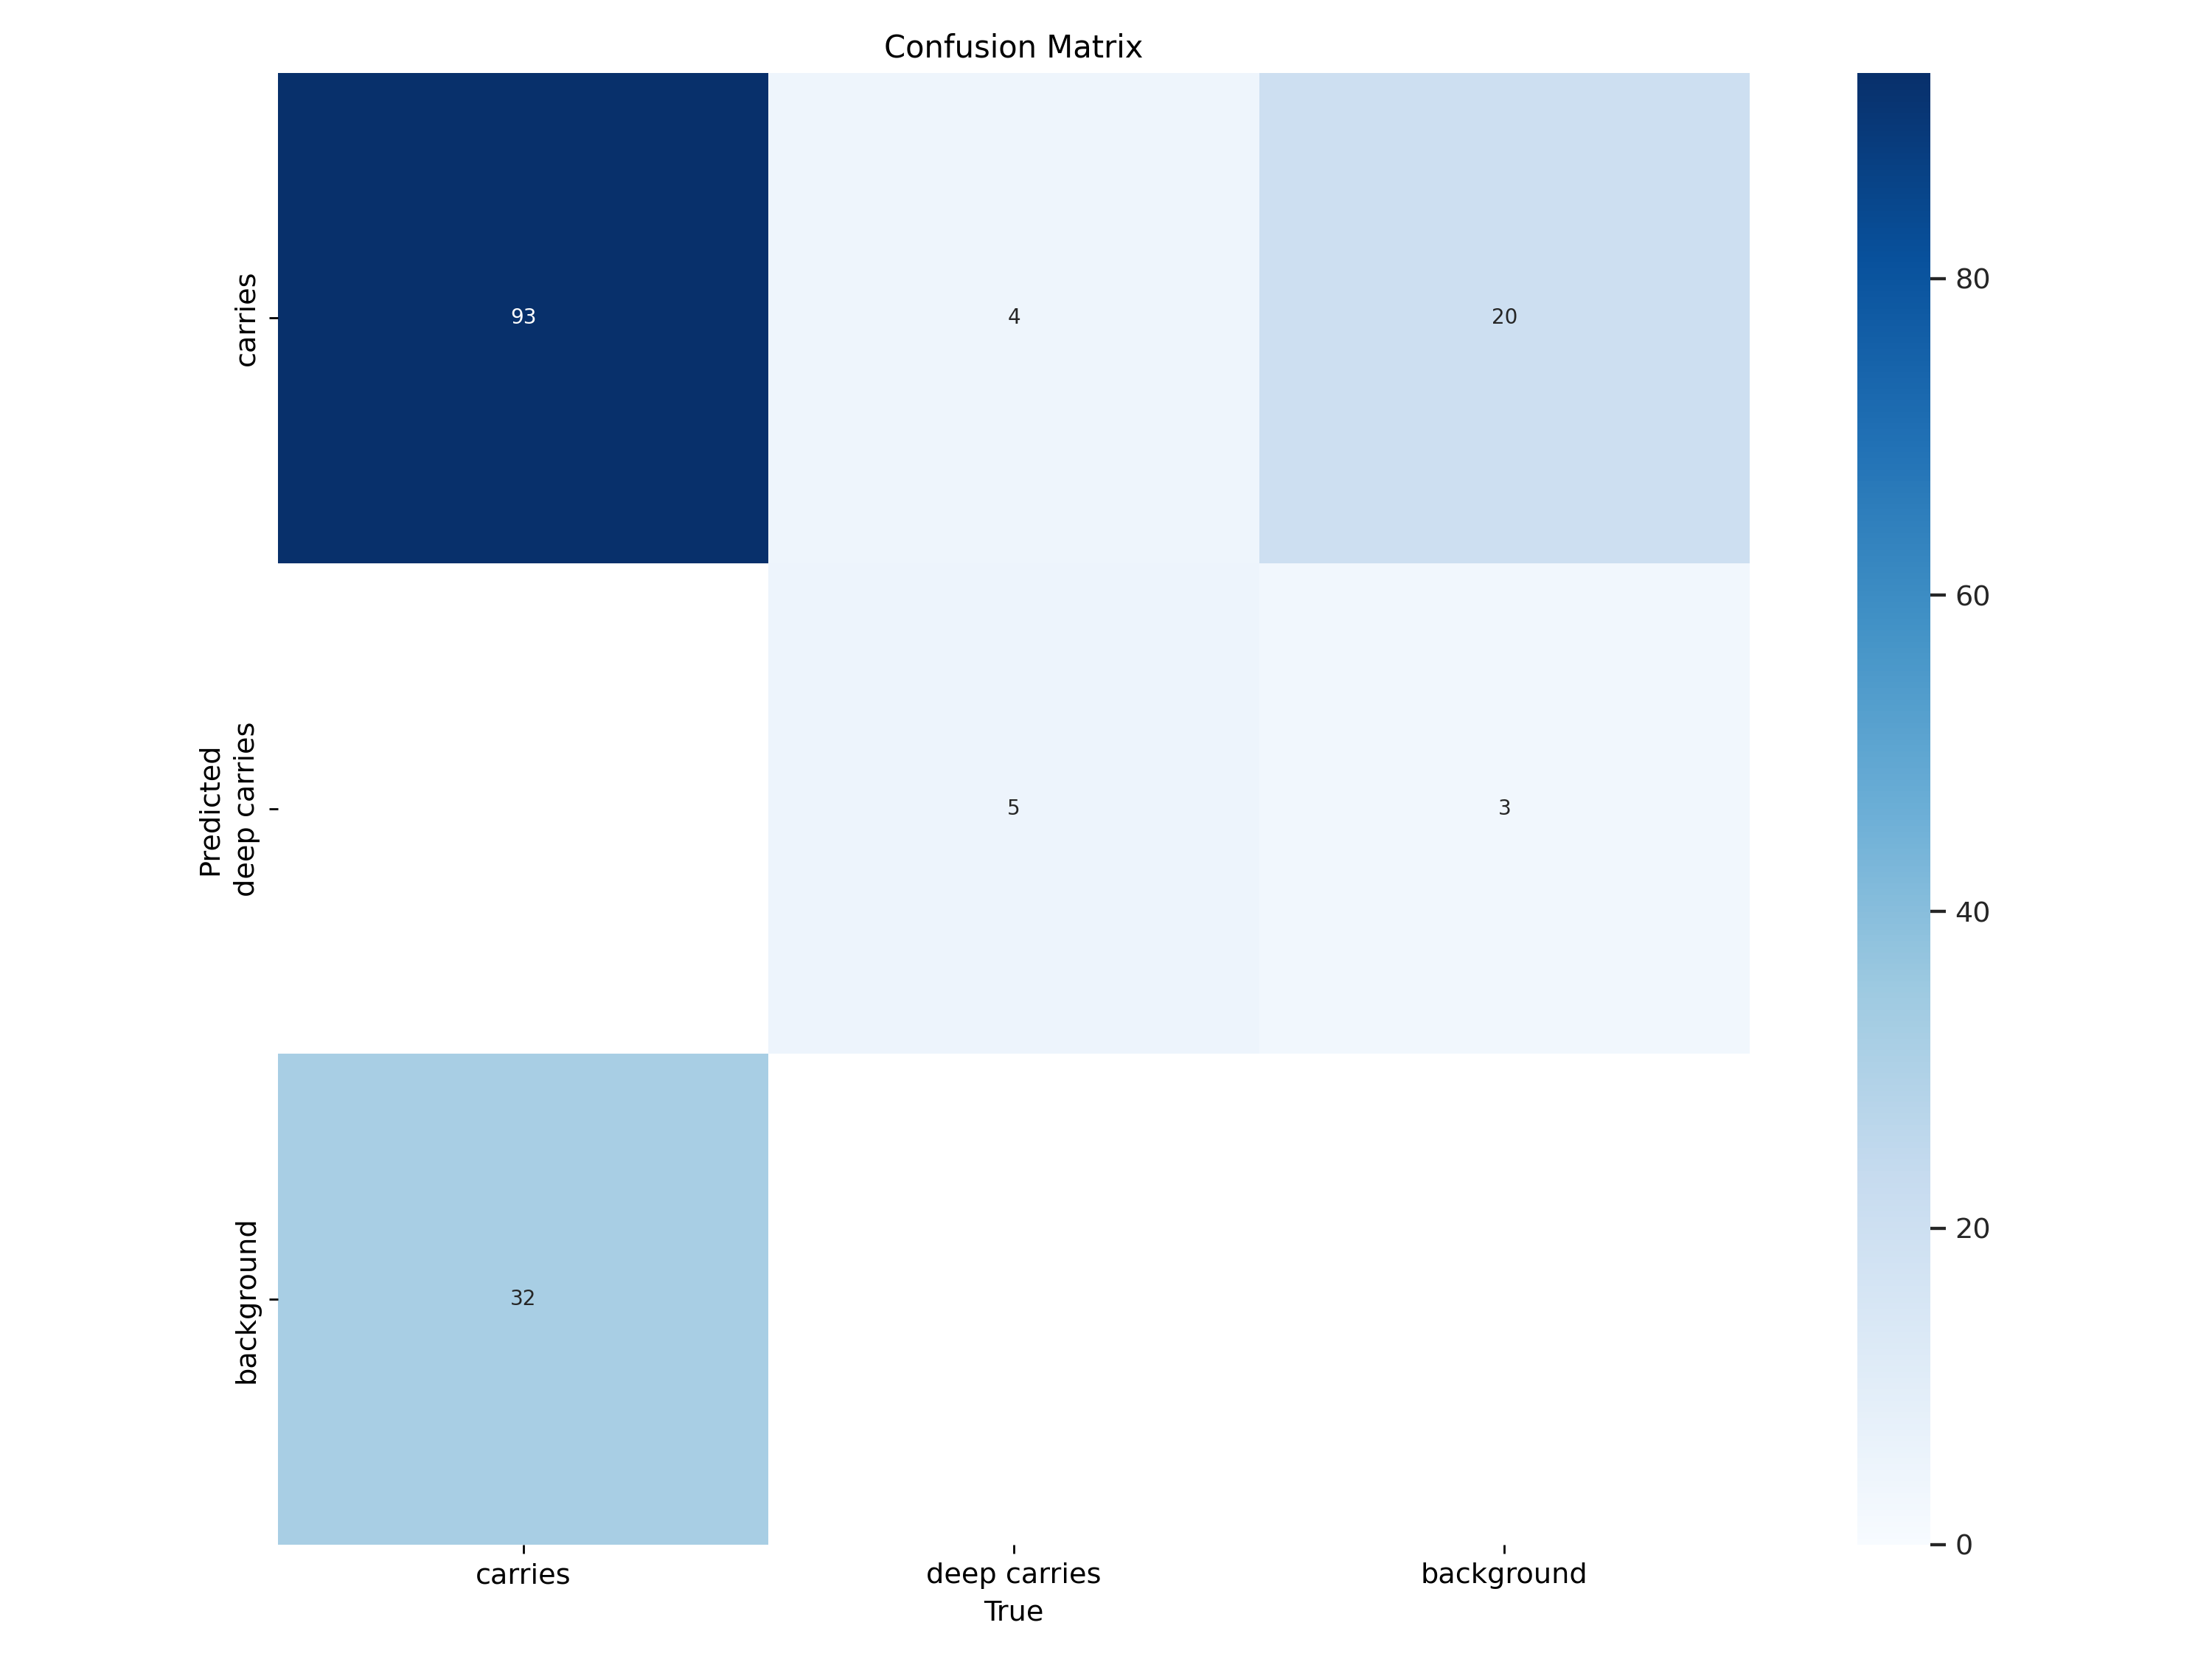

In [17]:
from IPython.display import Image as IPyImage

# Display the confusion matrix image from the specified directory in Kaggle
IPyImage(filename='/kaggle/working/runs/detect/caries_v1_aug/confusion_matrix.png', width=1000)


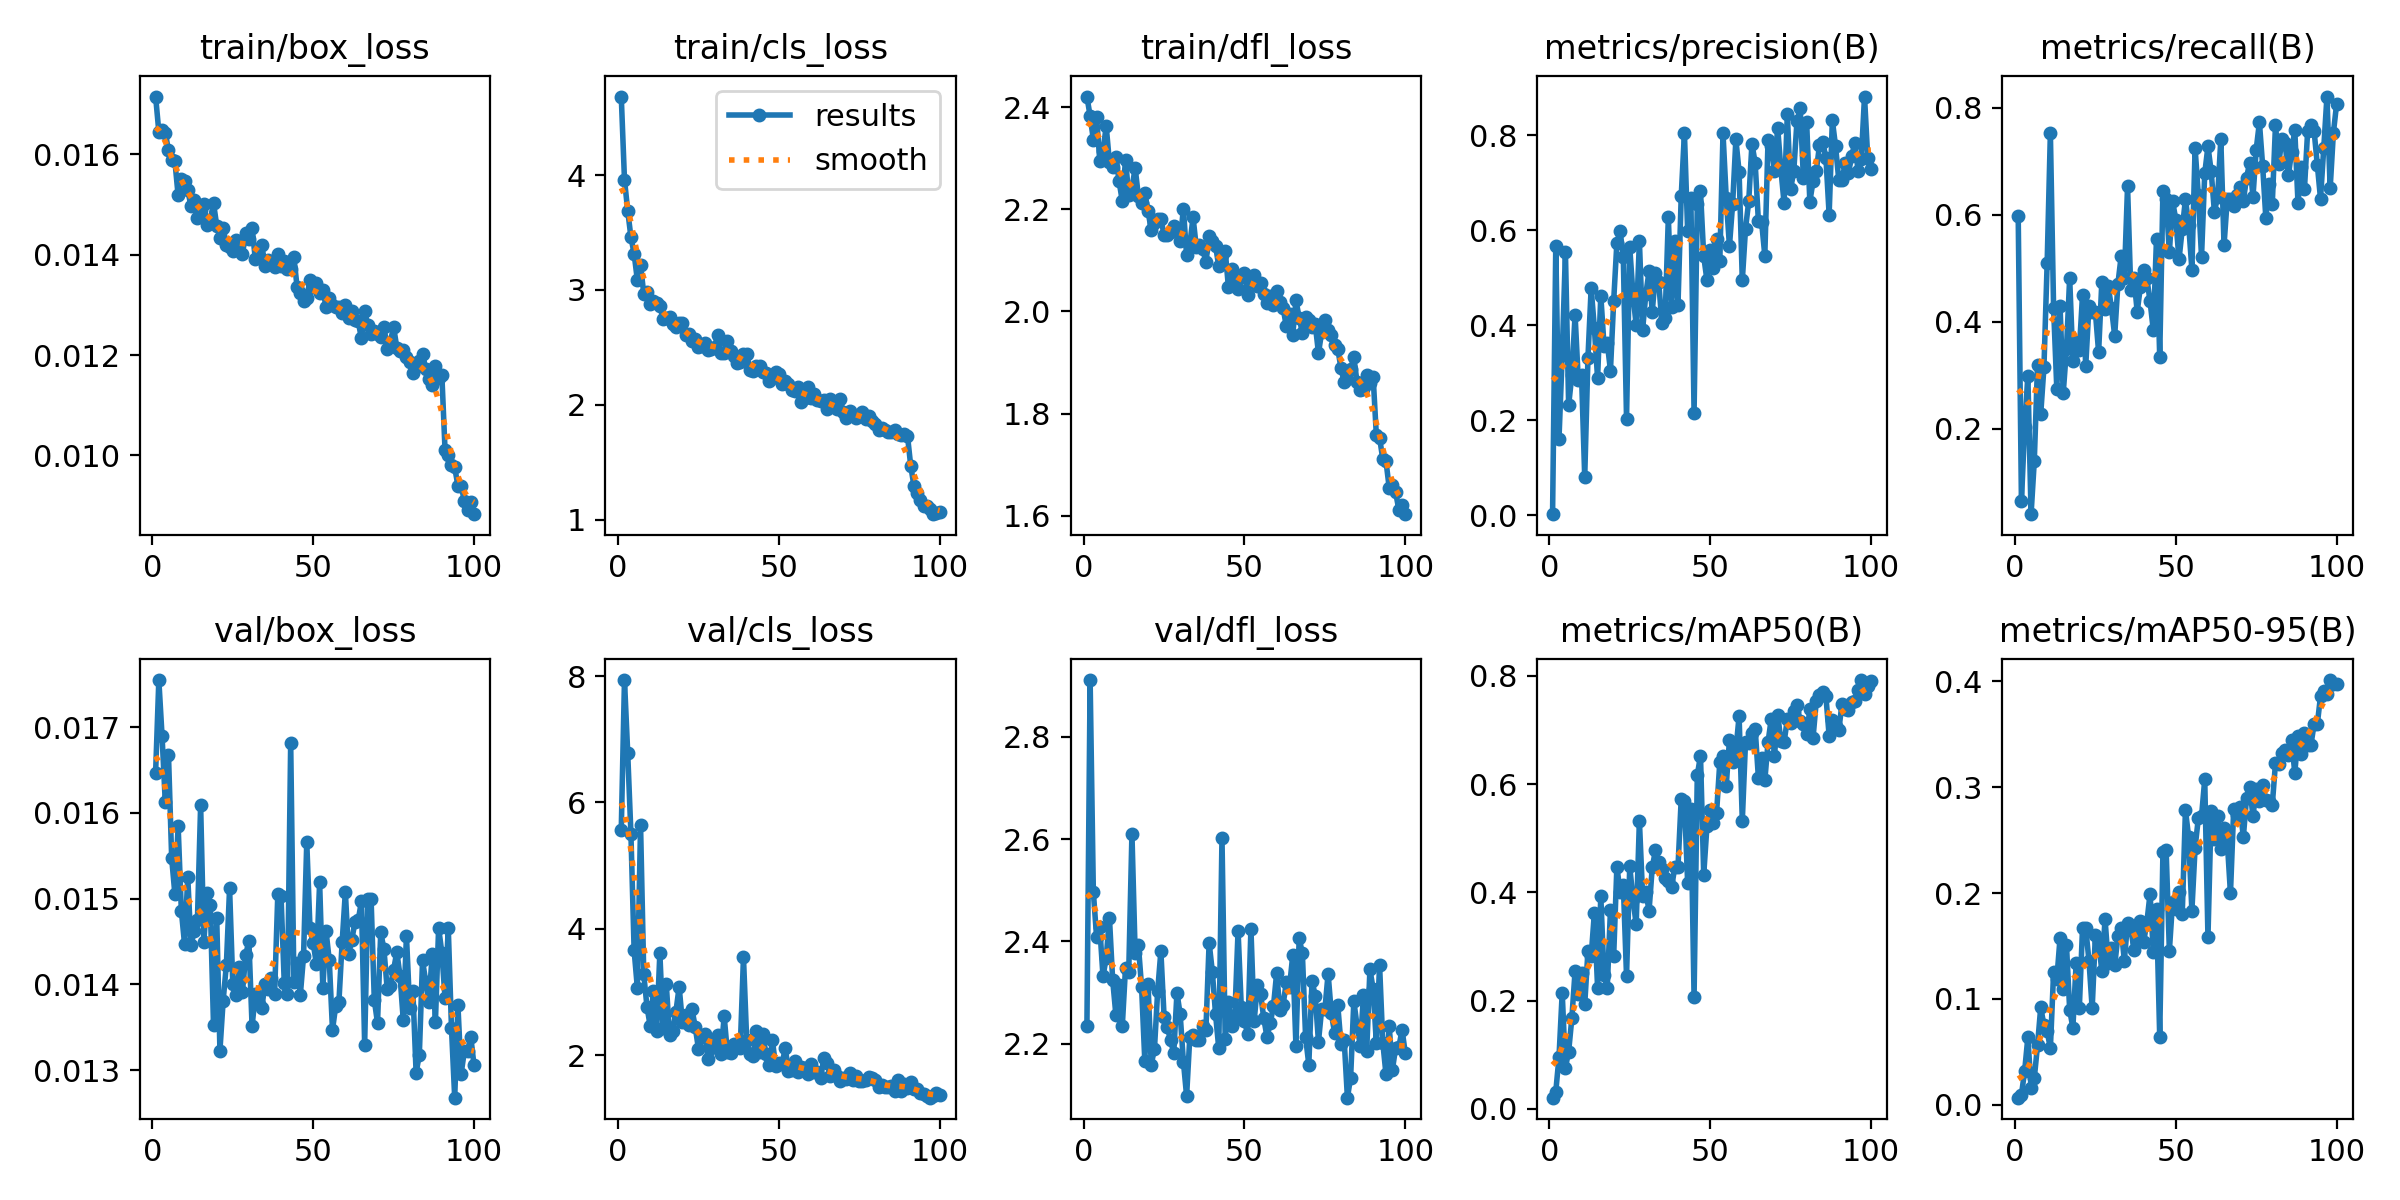

In [18]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/results.png', width=1000)

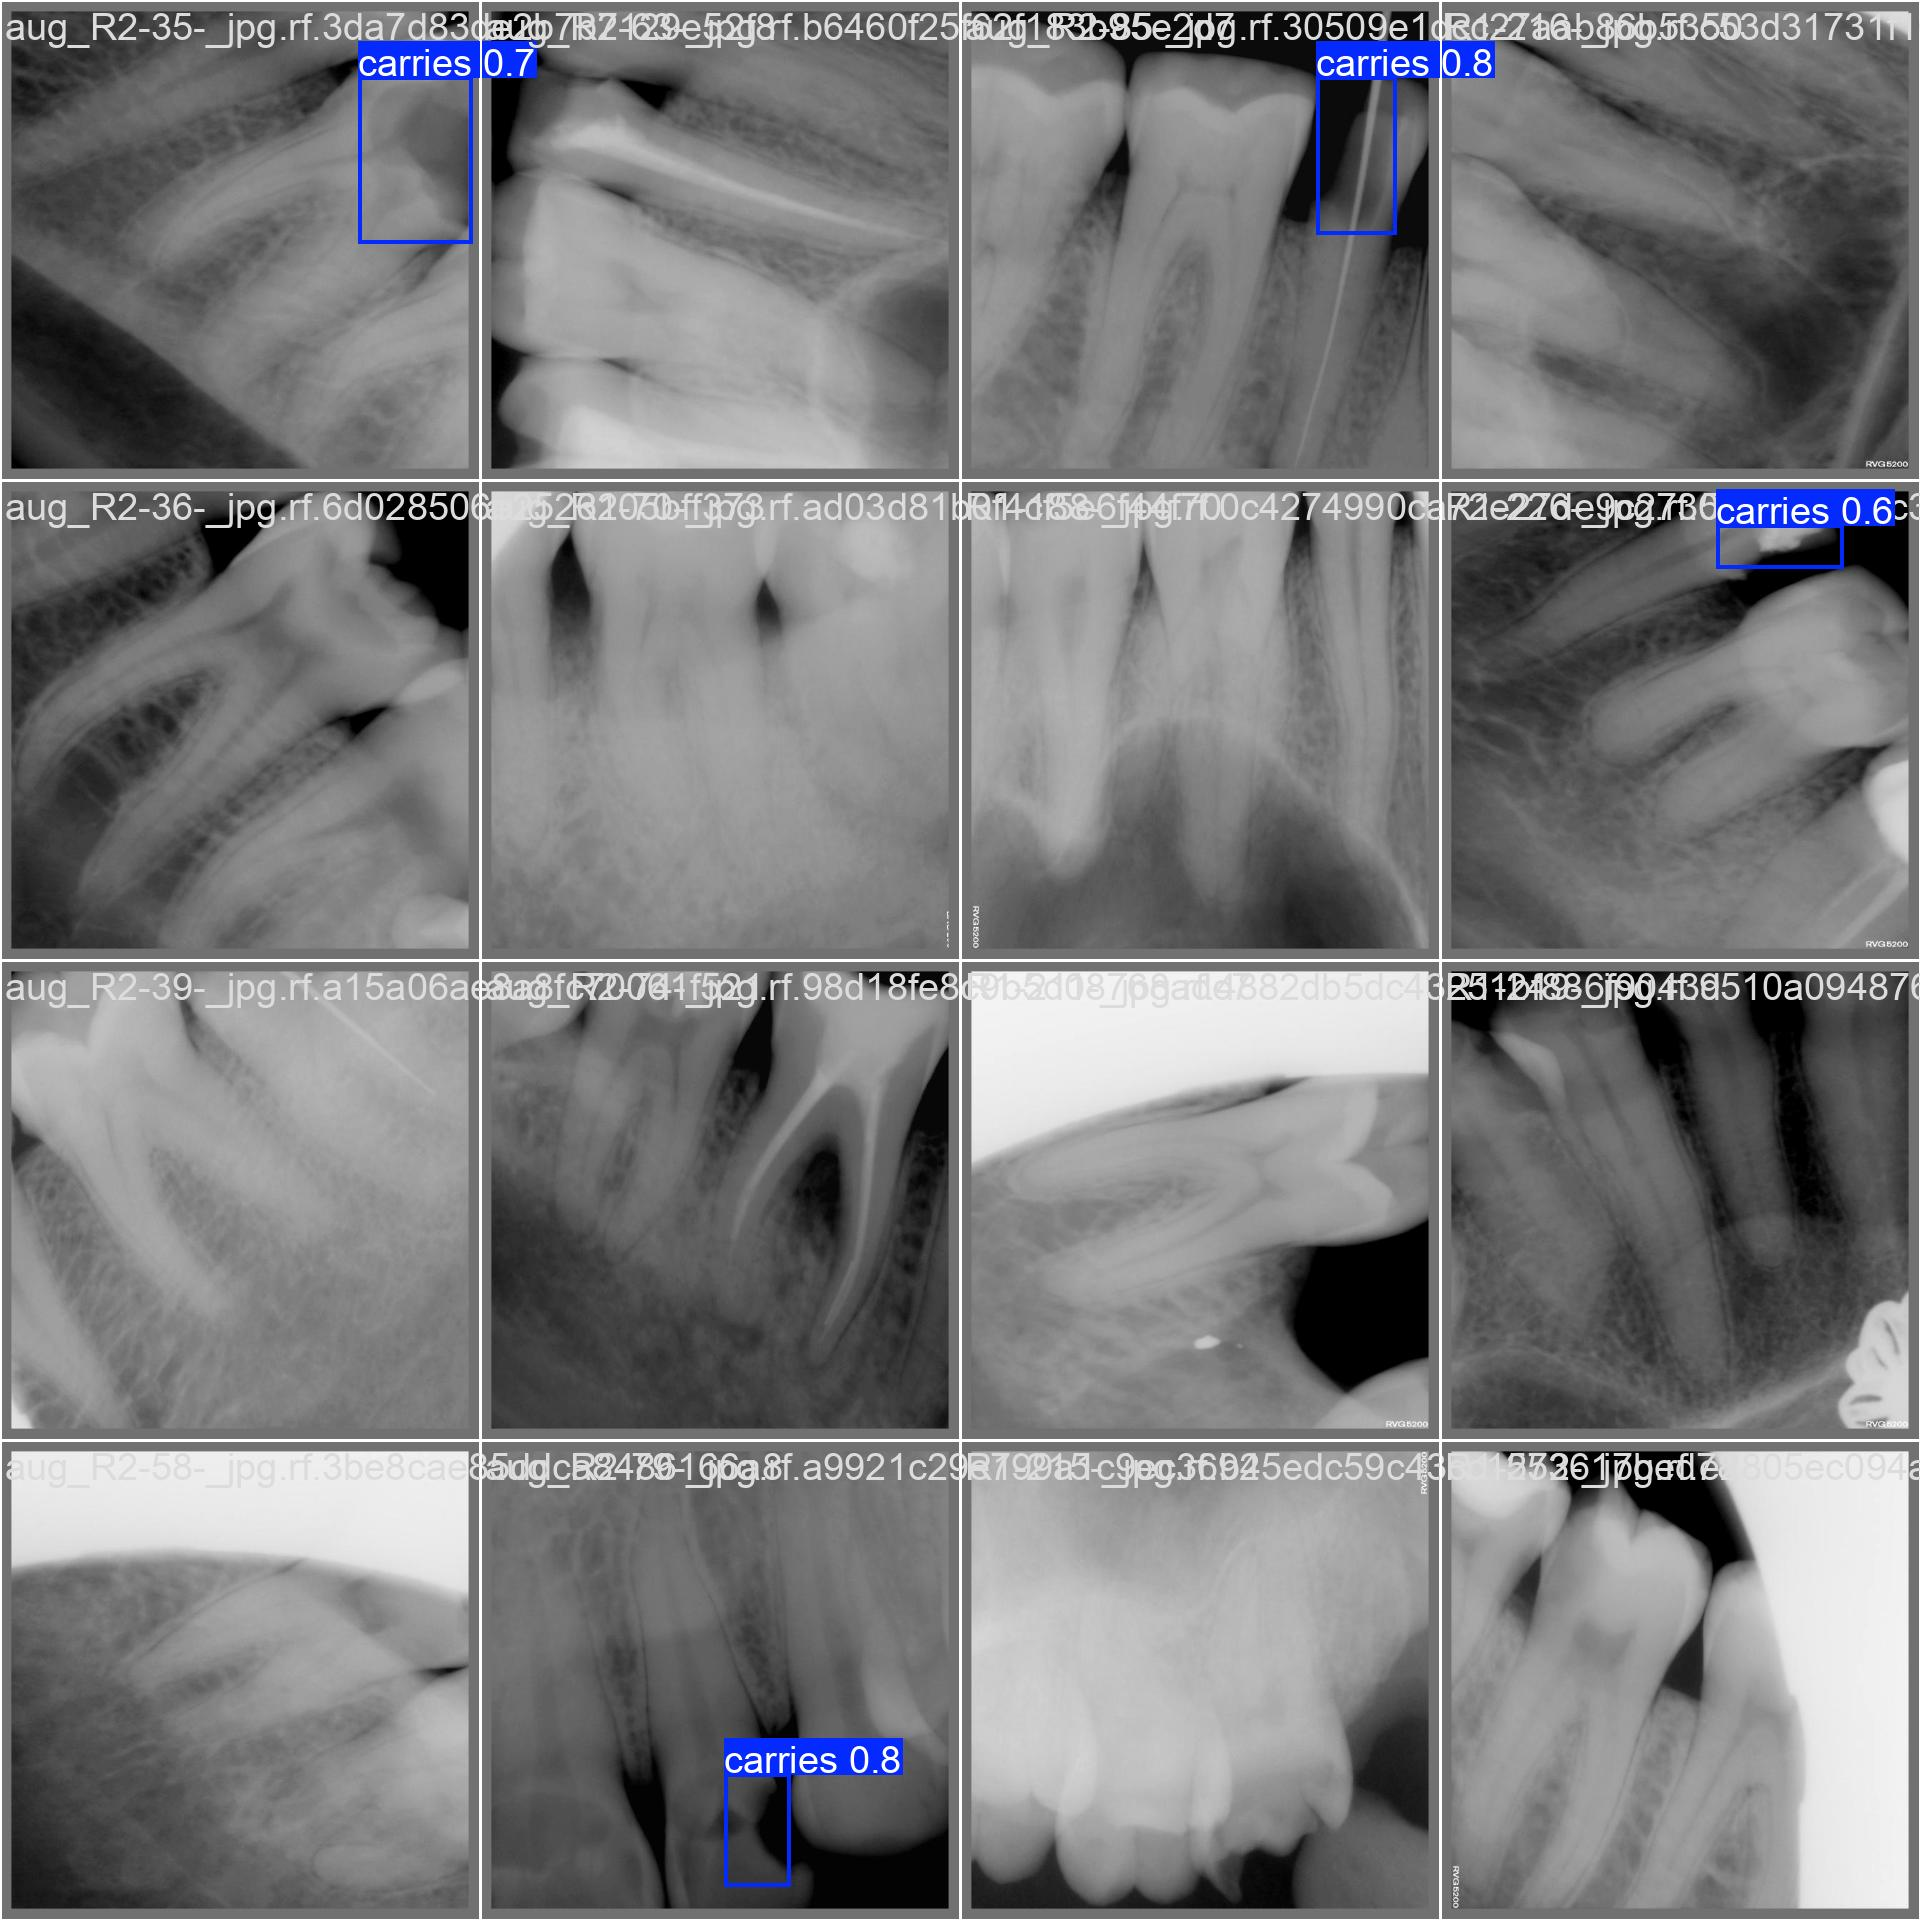

In [19]:
IPyImage(filename=f'/kaggle/working/runs/detect/caries_v1_aug/val_batch0_pred.jpg', width=1000)

In [20]:
# Run the validation task using YOLO in Kaggle
!yolo task=detect mode=val model=/kaggle/working/runs/detect/caries_v1_aug/weights/best.pt data=/kaggle/working/yolov11/data/caries_v1/data.yaml

Ultralytics 8.3.67 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /kaggle/working/yolov11/data/caries_v1/valid/labels.cache... 194 i
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        194        134      0.876      0.639      0.761      0.402
               carries        106        125      0.751      0.629      0.698      0.338
          deep carries          9          9          1       0.65      0.824      0.467
Speed: 1.8ms preprocess, 5.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [21]:
!git clone https://github.com/rigvedrs/YOLO-V8-CAM.git

Cloning into 'YOLO-V8-CAM'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 115 (delta 13), reused 8 (delta 8), pack-reused 94 (from 1)
Receiving objects: 100% (115/115), 41.00 MiB | 30.14 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [23]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torchvision.transforms as transforms
from PIL import Image
import io

In [24]:
!ls

YOLO-V8-CAM  runs  yolo11n.pt  yolov11


In [25]:
%cd /kaggle/working/YOLO-V8-CAM

/kaggle/working/YOLO-V8-CAM


In [26]:
!pip install ttach

In [27]:
from yolo_cam.eigen_cam import EigenCAM
from yolo_cam.utils.image import show_cam_on_image, scale_cam_image

In [28]:
img = cv2.imread('/kaggle/input/cariesdetectionindian/test/images/R1-212-_jpg.rf.5645214242cd0e2a59dba8510b9d3de6.jpg')
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255

In [37]:
model.cpu()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_

In [30]:
target_layers =[model.model.model[-19]]

In [31]:
cam = EigenCAM(model, target_layers,task='od')


0: 640x640 1 carries, 15.7ms
Speed: 3.2ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


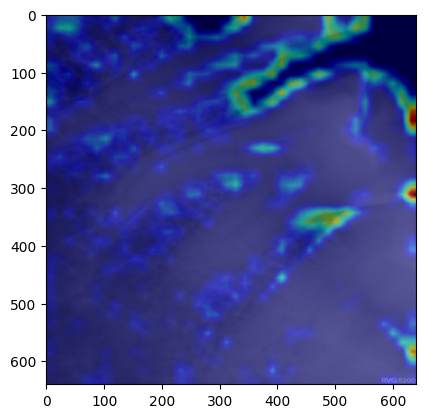

In [32]:
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [33]:
target_layers =[model.model.model[-18]]


0: 640x640 1 carries, 11.5ms
Speed: 2.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


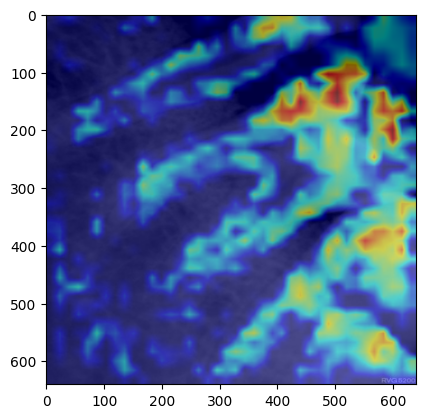

In [34]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [35]:
target_layers =[model.model.model[-15],model.model.model[-16], model.model.model[-17],model.model.model[-18]]



0: 640x640 1 carries, 12.6ms
Speed: 2.4ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


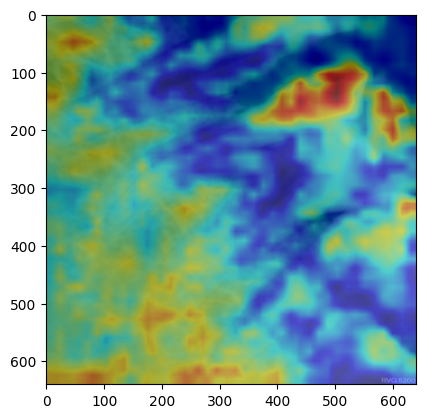

In [36]:
cam = EigenCAM(model, target_layers,task='od')
grayscale_cam = cam(rgb_img)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
plt.imshow(cam_image)
plt.show()

In [41]:
im = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
Image.fromarray(np.hstack((im, cam_image)))

In [42]:
list_of_metrics = ["R_curve.png", "confusion_matrix.png", "results.png"]

In [43]:
%cd /kaggle/working/

/kaggle/working


In [44]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


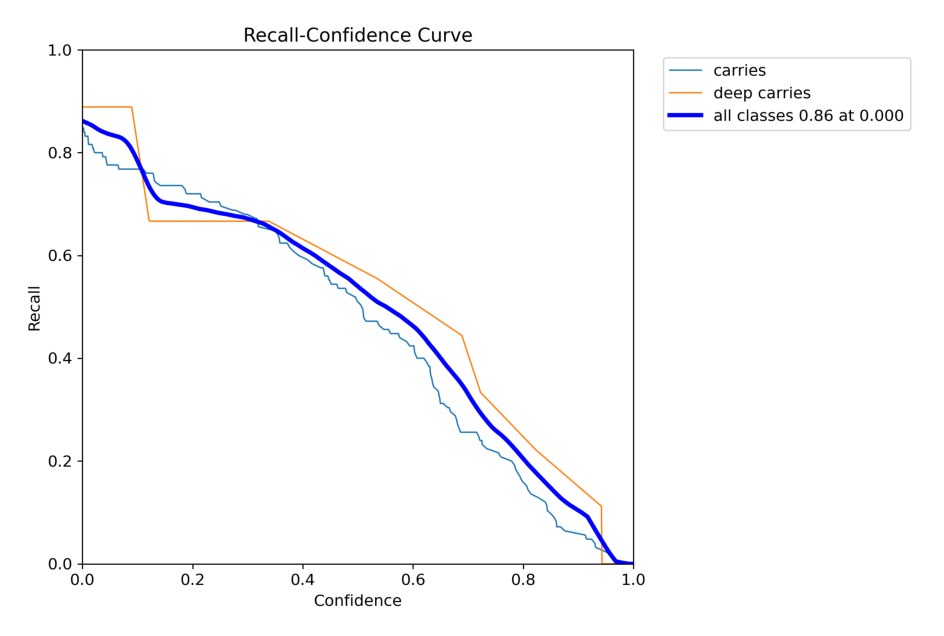

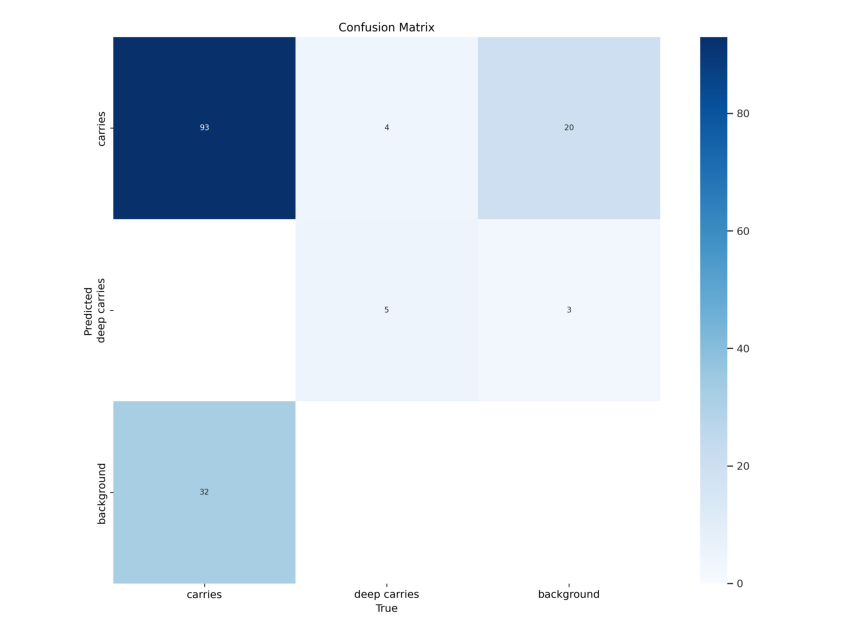

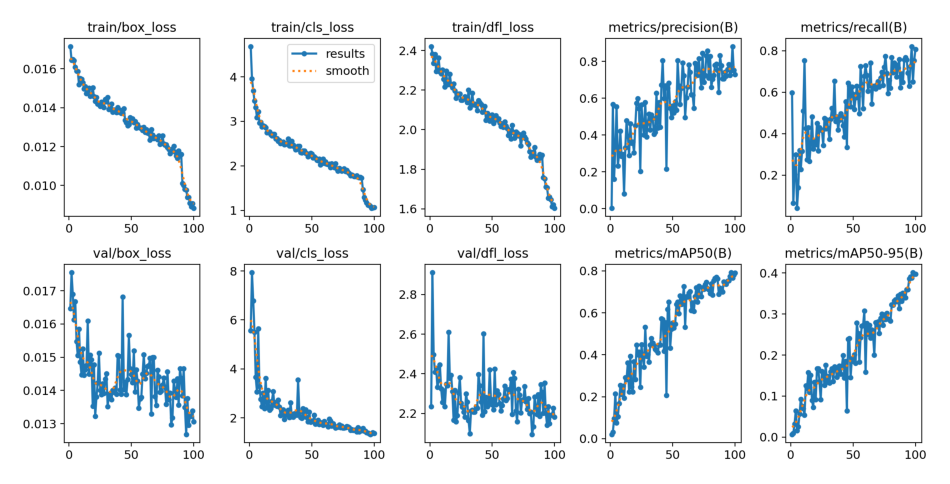

In [45]:
from PIL import Image
for i in list_of_metrics:

    image = Image.open(f'{HOME}/runs/detect/caries_v1_aug/{i}')

    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.imshow(image)
    plt.show()
